# Global Wheat Detection - Inference

You can get the training scripts [here](https://github.com/ufownl/global-wheat-detection).

* YOLOv3 from [GluonCV](https://gluon-cv.mxnet.io/)
* Use Darknet53 backbone

## Dataset

In [1]:
import mxnet as mx


def load_image(path):
    with open(path, "rb") as f:
        buf = f.read()
    return mx.image.imdecode(buf)


## Model

In [2]:
import mxnet as mx
import gluoncv as gcv


def load_model(path, ctx=mx.cpu()):
    net = gcv.model_zoo.yolo3_darknet53_custom(["wheat"], pretrained_base=False)
    net.set_nms(post_nms=150)
    net.load_parameters(path, ctx=ctx)
    return net


In [3]:
!ls -lh /kaggle/input/global-wheat-detection-models/global-wheat-yolo3-darknet53.params

-rw-r--r-- 1 nobody nogroup 236M May 11 18:35 /kaggle/input/global-wheat-detection-models/global-wheat-yolo3-darknet53.params


## Inference

Loading model...
/kaggle/input/global-wheat-detection/test/348a992bb.jpg


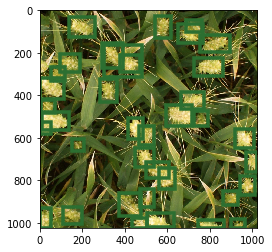

/kaggle/input/global-wheat-detection/test/796707dd7.jpg


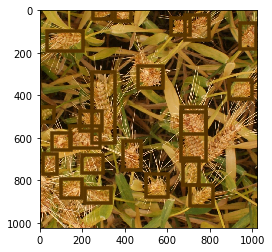

/kaggle/input/global-wheat-detection/test/aac893a91.jpg


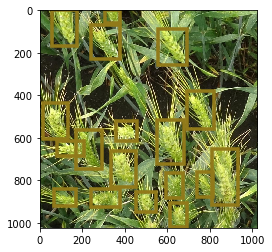

/kaggle/input/global-wheat-detection/test/f5a1f0358.jpg


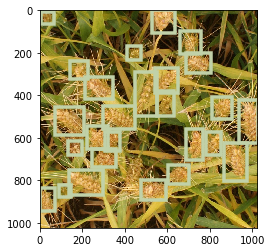

/kaggle/input/global-wheat-detection/test/cb8d261a3.jpg


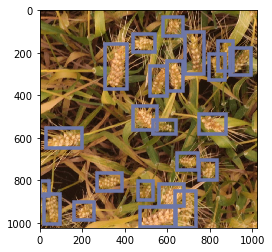

/kaggle/input/global-wheat-detection/test/cc3532ff6.jpg


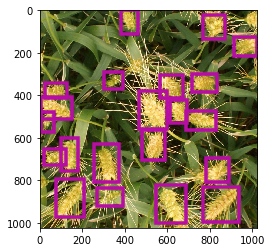

/kaggle/input/global-wheat-detection/test/51f1be19e.jpg


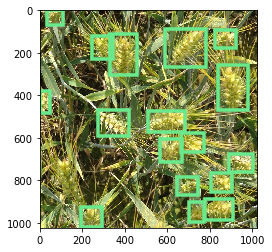

/kaggle/input/global-wheat-detection/test/51b3e36ab.jpg


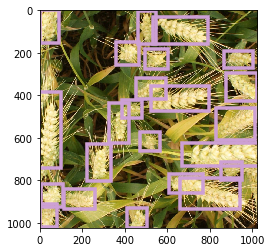

/kaggle/input/global-wheat-detection/test/53f253011.jpg


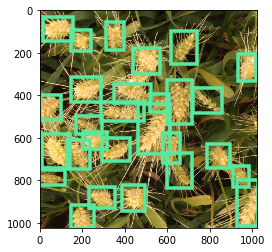

/kaggle/input/global-wheat-detection/test/2fd875eaa.jpg


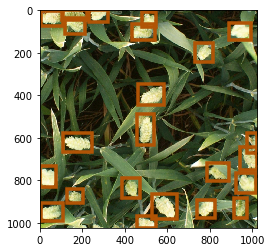

In [4]:
%matplotlib inline

import os
import mxnet as mx
import pandas as pd
import gluoncv as gcv
import matplotlib.pyplot as plt

images = [
    (os.path.join(dirname, filename), os.path.splitext(filename)[0])
        for dirname, _, filenames in os.walk('/kaggle/input/global-wheat-detection/test') for filename in filenames
]
threshold = 0.2
img_s = 512
context = mx.cpu()
results = []

print("Loading model...")
model = load_model("/kaggle/input/global-wheat-detection-models/global-wheat-yolo3-darknet53.params", ctx=context)
for path, image_id in images:
    print(path)
    raw = load_image(path)
    x, _ = gcv.data.transforms.presets.yolo.transform_test(raw, short=img_s)
    classes, scores, bboxes = model(x.as_in_context(context))
    bboxes[0, :, 0::2] = bboxes[0, :, 0::2] / x.shape[3] * raw.shape[1]
    bboxes[0, :, 1::2] = bboxes[0, :, 1::2] / x.shape[2] * raw.shape[0]
    gcv.utils.viz.plot_bbox(raw, [
        bboxes[0, i].asnumpy() for i in range(classes.shape[1])
            if model.classes[int(classes[0, i].asscalar())] == "wheat" and scores[0, i].asscalar() > threshold
    ])
    plt.show()
    bboxes[0, :, 2:4] -= bboxes[0, :, 0:2]
    results.append({
        "image_id": image_id,
        "PredictionString": " ".join([
            " ".join([str(x) for x in [scores[0, i].asscalar()] + [round(x) for x in bboxes[0, i].asnumpy().tolist()]])
                for i in range(classes.shape[1])
                    if model.classes[int(classes[0, i].asscalar())] == "wheat" and scores[0, i].asscalar() > threshold
        ])
    })
    
pd.DataFrame(results, columns=['image_id', 'PredictionString']).to_csv('submission.csv', index=False)
